In [1]:
%load_ext autoreload
%autoreload 2

import logging
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms as T
from torchvision.utils import save_image, make_grid

from vaemcmc.models.encoders import EncoderMLP
from vaemcmc.models.decoders import DecoderMLP
from vaemcmc.vae import VAE, VAETarget
from vaemcmc.mcmc import ISIRKernel
from vaemcmc.dataset import SyntheticDataset
from vaemcmc.trainer import Trainer
from vaemcmc.distributions.likelihood import BernoulliLikelihood
from vaemcmc.viz.synthetic import plot_kde, plot_chain, scatter
from vaemcmc.models.rnvp import RNVP, FlowML

from vaemcmc.distributions.synthetic import MoG


/Users/evgeny/miniconda3/envs/vaemcmc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 / 255.  # input threshold for [0..255] gray level, convert to [0..1]

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  # do not change the data type

transform = T.Compose([
    T.ToTensor(),
    # T.ConvertImageDtype(torch.long),
    ThresholdTransform(thr_255=240),
    # T.ConvertImageDtype(torch.float)
])

train_dataset = MNIST('./data', True, transform=transform, download=True)
val_dataset = MNIST('./data', False, transform=transform, download=True)

AMB_DIM = 784
LAT_DIM = 32


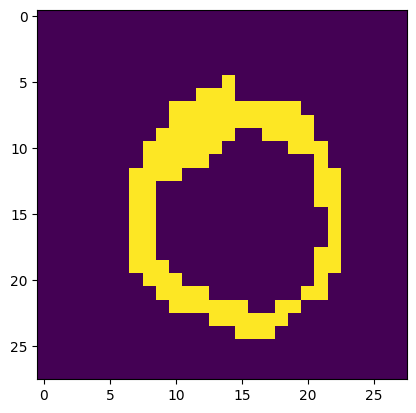

In [4]:
x, _ = train_dataset[56]
plt.imshow(x.permute(1, 2, 0).numpy())

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=16)

encoder = EncoderMLP(AMB_DIM, 2 * LAT_DIM, 100, n_layers=3)
decoder = DecoderMLP(LAT_DIM, AMB_DIM, 100, n_layers=3)

# sigma = 1.
# likelihood = NormalLikelihood(sigma)
likelihood = BernoulliLikelihood(logits=True)

vae = VAE(encoder, decoder, likelihood)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

logging.basicConfig(format='%(asctime)s [%(levelname)-8s] %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)
    
trainer = Trainer(vae, optimizer, train_dataloader, val_dataloader=val_dataloader, logger=logger)


In [6]:
trainer.train(20)

2023-05-29 16:50:34,416 [INFO    ] 0%|          | 0/10 [00:00<?, ?it/s]
2023-05-29 16:50:38,673 [INFO    ] Loss: 125.46380615234375
2023-05-29 16:50:42,862 [INFO    ] Loss: 111.8503189086914
2023-05-29 16:50:47,549 [INFO    ] Loss: 91.09747314453125
2023-05-29 16:50:51,744 [INFO    ] 10%|#         | 1/10 [00:17<02:35, 17.32s/it]
2023-05-29 16:50:53,078 [INFO    ] Loss: 102.28103637695312
2023-05-29 16:50:57,904 [INFO    ] Loss: 111.8785171508789
2023-05-29 16:51:02,145 [INFO    ] Loss: 91.49633026123047
2023-05-29 16:51:06,693 [INFO    ] Loss: 97.44609832763672
2023-05-29 16:51:09,039 [INFO    ] 20%|##        | 2/10 [00:34<02:18, 17.31s/it]
2023-05-29 16:51:11,199 [INFO    ] Loss: 101.15611267089844
2023-05-29 16:51:15,372 [INFO    ] Loss: 88.86441802978516
2023-05-29 16:51:19,577 [INFO    ] Loss: 88.3248291015625
2023-05-29 16:51:23,864 [INFO    ] Loss: 104.07901000976562
2023-05-29 16:51:25,055 [INFO    ] 30%|###       | 3/10 [00:50<01:57, 16.72s/it]
2023-05-29 16:51:28,826 [INFO    

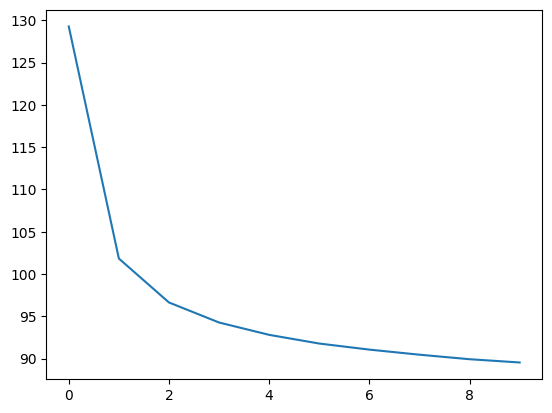

In [7]:
plt.plot(trainer.training_stats['epoch_loss'])

2023-05-29 16:53:54,765 [WARNING ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


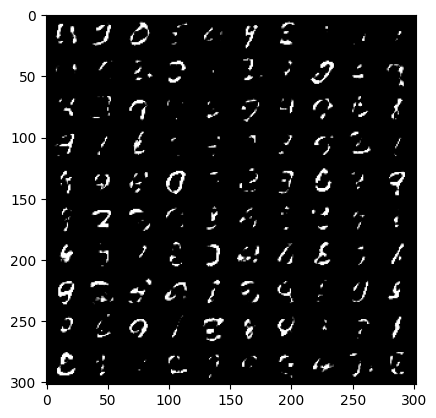

In [8]:
vae_sample = vae.sample((100,)).detach().cpu()
vae_sample = vae_sample.reshape(-1, 1, 28, 28)
grid = make_grid(vae_sample, nrow=10)

plt.imshow(grid.permute(1, 2, 0))